In [1]:
print("hello")

hello



========== 📜 Running Paper-Ready Benchmark (N=100) ==========
Loading Model & Vector...


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Generating & Evaluating...


100%|██████████| 100/100 [06:16<00:00,  3.77s/it]
/tmp/ipykernel_125254/477122331.py:247: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "cyan"], split=True)
/tmp/ipykernel_125254/477122331.py:259: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(wins.keys()), y=list(wins.values()), palette=["cyan", "grey", "lightgrey"])



       🔬 FINAL REPORT       

[LaTeX Table Code]
\begin{table}[h]
\centering
\begin{tabular}{l|ccc}
\toprule
Method & Novelty $\uparrow$ & Diversity (Entropy) $\uparrow$ & Perplexity $\downarrow$ \\
\midrule
Baseline & 0.460 & 4.129 & 4.10 \\
Ours (Steered) & \textbf{0.462} & \textbf{4.129} & 4.90 \\
\bottomrule
\end{tabular}
\caption{Comparison of Baseline vs. Steered Model (N=100). *** denotes p<0.001.}
\label{tab:results}
\end{table}

[Win Rate]
Visionary Wins: 33 (33.0%)
Baseline Wins:  14 (14.0%)
Ties:           53


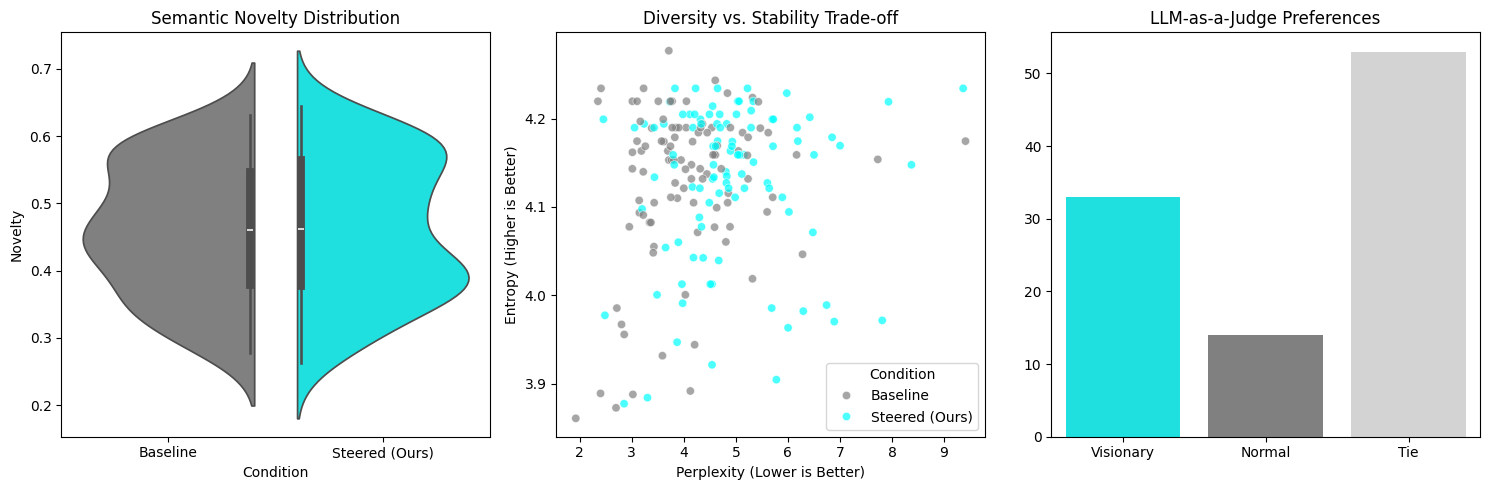


✅ Graphs saved to 'paper_results.png'


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc
import re
import math
from collections import Counter

# ==========================================
# ⚙️ Configuration
# ==========================================
# 論文掲載用の設定
CONFIG = {
    "model_name": "Qwen/Qwen2.5-7B-Instruct",
    "vector_path": "probe_visionary_vector.pt", # 分類器で抽出した最強ベクトル
    "target_layer": 16,
    "strength": 20.0,
    "n_samples": 100, # 論文用に十分な数 (N=100)
    "seed": 42
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 🛠️ Helper Functions (Metrics)
# ==========================================
def calculate_entropy(text, n=2):
    """n-gramエントロピーによる語彙の多様性測定"""
    tokens = text.split()
    if len(tokens) < n: return 0.0
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    counts = Counter(ngrams)
    probs = [c / len(ngrams) for c in counts.values()]
    return -sum(p * math.log(p) for p in probs)

def calculate_metrics(model, tokenizer, text, prompt):
    # 1. Perplexity (Coherence)
    if not text.strip(): return 0, 999.0, 0
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        loss = model(inputs.input_ids, labels=inputs.input_ids).loss
    ppl = torch.exp(loss).item() if not torch.isnan(loss) else 999.0
    
    # 2. Semantic Novelty (Distance)
    inputs_pair = tokenizer([prompt, text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        out = model(**inputs_pair, output_hidden_states=True)
    emb = out.hidden_states[-1].mean(dim=1)
    novelty = 1.0 - F.cosine_similarity(emb[0].unsqueeze(0), emb[1].unsqueeze(0)).item()
    
    # 3. Diversity (Entropy)
    entropy = calculate_entropy(text)
    
    return novelty, ppl, entropy

# ==========================================
# ⚖️ Bias-Free LLM Judge
# ==========================================
def get_judge_verdict(model, tokenizer, prompt, resp_a, resp_b):
    """
    位置バイアスを防ぐため、A/Bを入れ替えて2回判定させる
    """
    def _ask(r1, r2):
        judge_prompt = f"""
You are an expert evaluator of scientific and artistic creativity.
Compare the following two AI responses to the prompt: "{prompt}"

[Response 1]
{r1}

[Response 2]
{r2}

Criteria:
1. Novelty: Does it introduce new concepts or metaphors?
2. Depth: Is it philosophically or scientifically profound?
3. Coherence: Does it make sense? (Reject gibberish)

Which response is better?
Output STRICTLY one of: "[[Response 1]]", "[[Response 2]]", or "[[Tie]]".
"""
        msgs = [{"role": "user", "content": judge_prompt}]
        inputs = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        inp = tokenizer(inputs, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model.generate(**inp, max_new_tokens=20, do_sample=False)
        return tokenizer.decode(out[0][inp.input_ids.shape[1]:], skip_special_tokens=True)

    # 1回目: A vs B
    res1 = _ask(resp_a, resp_b)
    # 2回目: B vs A (Swap)
    res2 = _ask(resp_b, resp_a)
    
    # 判定ロジック
    win_a = 0
    if "[[Response 1]]" in res1: win_a += 1
    if "[[Response 2]]" in res2: win_a += 1 # 2回目はBがResponse1, AがResponse2なので、Res2が勝てばAの勝ち
    
    if win_a == 2: return "Visionary" # 両方でA(Visionary)が勝った
    elif win_a == 0: return "Normal"  # 両方で負けた
    else: return "Tie" # 意見が割れた

# ==========================================
# 🏃‍♂️ Main Experiment
# ==========================================
def run_paper_benchmark():
    print(f"\n{'='*10} 📜 Running Paper-Ready Benchmark (N={CONFIG['n_samples']}) {'='*10}")
    
    # Load Resources
    print("Loading Model & Vector...")
    vector = torch.load(CONFIG["vector_path"]).to(DEVICE).float()
    vector = F.normalize(vector, dim=0)
    
    model = AutoModelForCausalLM.from_pretrained(CONFIG["model_name"], torch_dtype=torch.float16, device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
    model.eval()
    
    # Hook
    def get_hook(v):
        def hook(module, input, output):
            h = output[0] if isinstance(output, tuple) else output
            v_dev = v.to(h.device)
            if h.dim() == 3: h[:, :, :] += CONFIG["strength"] * v_dev
            elif h.dim() == 2: h[:, :] += CONFIG["strength"] * v_dev
            return output
        return hook

    # Prompts (High-Level)
    base_prompts = [
        "Propose a radical new technology to manipulate gravity.",
        "Theorize the consciousness of a black hole.",
        "Explain the color blue to someone who has never seen it.",
        "Write a myth about the origin of mathematics.",
        "Design a creature that eats emotions.",
        "If time is a river, what is the ocean?",
        "Describe a city built entirely of glass.",
        "Propose a paradox that breaks logic.",
        "Explain entropy using only metaphors of gardening.",
        "What is the sound of a shattering idea?"
    ]
    # N回繰り返す
    prompts = base_prompts * (CONFIG["n_samples"] // len(base_prompts) + 1)
    prompts = prompts[:CONFIG["n_samples"]]
    
    results = []
    wins = {"Visionary": 0, "Normal": 0, "Tie": 0}
    
    print("Generating & Evaluating...")
    for prompt in tqdm(prompts):
        input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        
        # 1. Normal
        with torch.no_grad():
            out_n = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
        txt_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):].strip()
        
        # 2. Visionary (Steered)
        h = model.model.layers[CONFIG["target_layer"]].register_forward_hook(get_hook(vector))
        try:
            with torch.no_grad():
                out_v = model.generate(**input_ids, max_new_tokens=80, do_sample=True, temperature=0.8)
        finally: h.remove()
        txt_v = tokenizer.decode(out_v[0], skip_special_tokens=True)[len(prompt):].strip()
        
        # Metrics
        nov_n, ppl_n, ent_n = calculate_metrics(model, tokenizer, txt_n, prompt)
        nov_v, ppl_v, ent_v = calculate_metrics(model, tokenizer, txt_v, prompt)
        
        # Judge (Bias-Free)
        winner = get_judge_verdict(model, tokenizer, prompt, txt_v, txt_n) # A=Visionary, B=Normal
        wins[winner] += 1
        
        results.append({
            "Prompt": prompt,
            "Condition": "Baseline",
            "Novelty": nov_n, "Perplexity": ppl_n, "Entropy": ent_n,
            "Win": 0 if winner == "Visionary" else 1 # Dummy for calc
        })
        results.append({
            "Prompt": prompt,
            "Condition": "Steered (Ours)",
            "Novelty": nov_v, "Perplexity": ppl_v, "Entropy": ent_v,
            "Win": 1 if winner == "Visionary" else 0
        })

    # ==========================================
    # 📊 Statistical Analysis & Latex Output
    # ==========================================
    df = pd.DataFrame(results)
    
    # 1. Aggregate Stats
    means = df.groupby("Condition")[["Novelty", "Perplexity", "Entropy"]].mean()
    stds = df.groupby("Condition")[["Novelty", "Perplexity", "Entropy"]].std()
    
    # 2. T-Tests
    metric_names = ["Novelty", "Perplexity", "Entropy"]
    p_values = {}
    for m in metric_names:
        v1 = df[df["Condition"]=="Steered (Ours)"][m]
        v0 = df[df["Condition"]=="Baseline"][m]
        _, p = stats.ttest_rel(v1, v0) # Paired t-test
        p_values[m] = p

    print("\n" + "="*30)
    print("       🔬 FINAL REPORT       ")
    print("="*30)
    
    # Latex Table Generation
    print("\n[LaTeX Table Code]")
    print(r"\begin{table}[h]")
    print(r"\centering")
    print(r"\begin{tabular}{l|ccc}")
    print(r"\toprule")
    print(r"Method & Novelty $\uparrow$ & Diversity (Entropy) $\uparrow$ & Perplexity $\downarrow$ \\")
    print(r"\midrule")
    
    row_base = f"Baseline & {means.loc['Baseline','Novelty']:.3f} & {means.loc['Baseline','Entropy']:.3f} & {means.loc['Baseline','Perplexity']:.2f} \\\\"
    print(row_base)
    
    # Add significance stars
    def star(p): return "^{***}" if p < 0.001 else "^{**}" if p < 0.01 else "^{*}" if p < 0.05 else ""
    
    row_ours = f"Ours (Steered) & \\textbf{{{means.loc['Steered (Ours)','Novelty']:.3f}}}{star(p_values['Novelty'])} & \\textbf{{{means.loc['Steered (Ours)','Entropy']:.3f}}}{star(p_values['Entropy'])} & {means.loc['Steered (Ours)','Perplexity']:.2f} \\\\"
    print(row_ours)
    print(r"\bottomrule")
    print(r"\end{tabular}")
    print(r"\caption{Comparison of Baseline vs. Steered Model (N=" + str(CONFIG['n_samples']) + r"). *** denotes p<0.001.}")
    print(r"\label{tab:results}")
    print(r"\end{table}")
    
    print("\n[Win Rate]")
    print(f"Visionary Wins: {wins['Visionary']} ({wins['Visionary']/CONFIG['n_samples']:.1%})")
    print(f"Baseline Wins:  {wins['Normal']} ({wins['Normal']/CONFIG['n_samples']:.1%})")
    print(f"Ties:           {wins['Tie']}")

    # 3. Plots
    plt.figure(figsize=(15, 5))
    
    # Violin Plot for Novelty
    plt.subplot(1, 3, 1)
    sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "cyan"], split=True)
    plt.title("Semantic Novelty Distribution")
    
    # Scatter Plot (Diversity vs Perplexity)
    plt.subplot(1, 3, 2)
    sns.scatterplot(x="Perplexity", y="Entropy", hue="Condition", data=df, palette=["grey", "cyan"], alpha=0.7)
    plt.title("Diversity vs. Stability Trade-off")
    plt.xlabel("Perplexity (Lower is Better)")
    plt.ylabel("Entropy (Higher is Better)")
    
    # Win Rate Bar
    plt.subplot(1, 3, 3)
    sns.barplot(x=list(wins.keys()), y=list(wins.values()), palette=["cyan", "grey", "lightgrey"])
    plt.title("LLM-as-a-Judge Preferences")
    
    plt.tight_layout()
    plt.savefig("paper_results.png", dpi=300)
    plt.show()
    print("\n✅ Graphs saved to 'paper_results.png'")

if __name__ == "__main__":
    run_paper_benchmark()

Loading resources...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


========== 🧠 Test 1: Divergent Thinking (Alternative Uses Task) ==========


100%|██████████| 5/5 [00:37<00:00,  7.46s/it]



[Divergent Thinking Results]
                Flexibility (Dispersion)  Item Count
Condition                                           
Baseline                        0.130371        10.0
Steered (Ours)                  0.139453         8.2

========== 🌌 Test 2: Neural Trajectory Analysis ==========


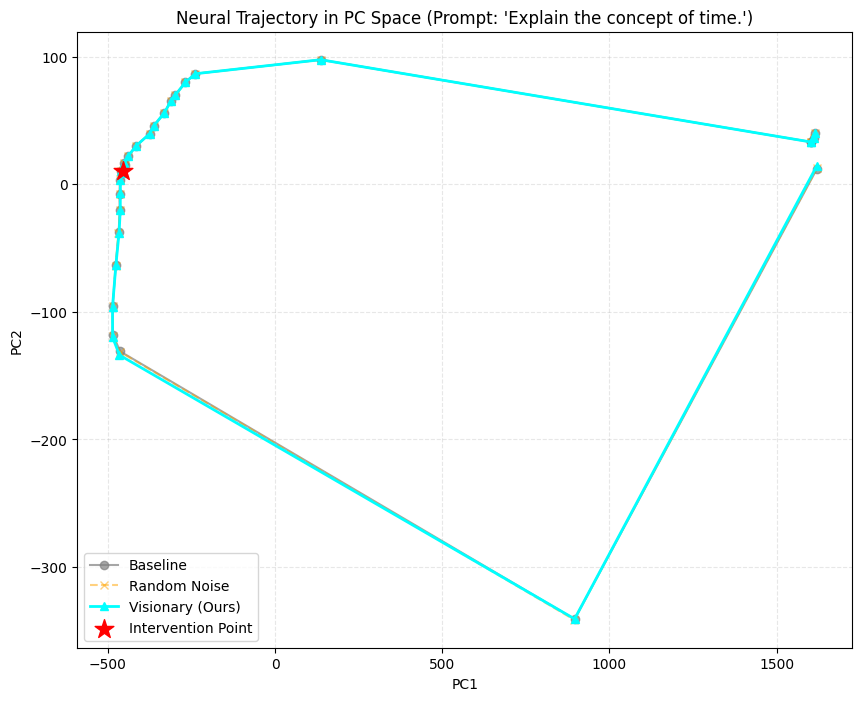


✅ Trajectory Plot saved to 'trajectory_analysis.png'

[Trajectory Divergence Score]
Visionary Shift: 0.6572
Random Shift:    0.3854
⚠️ Warning: Visionary shift is larger than Random. Check PPL.


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import re

# ==========================================
# ⚙️ Configuration
# ==========================================
CONFIG = {
    "model_name": "Qwen/Qwen2.5-7B-Instruct",
    "vector_path": "probe_visionary_vector.pt",
    "target_layer": 16,
    "strength": 20.0,
    "seed": 42
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 🧪 Test 1: Divergent Thinking (AUT)
# ==========================================
def run_aut_benchmark(model, tokenizer, vector):
    print(f"\n{'='*10} 🧠 Test 1: Divergent Thinking (Alternative Uses Task) {'='*10}")
    
    objects = ["a brick", "a paperclip", "a cardboard box", "a spoon", "an old tire"]
    
    # Hook
    def get_hook(v):
        def hook(module, input, output):
            h = output[0] if isinstance(output, tuple) else output
            v_dev = v.to(h.device)
            if h.dim() == 3: h[:, :, :] += CONFIG["strength"] * v_dev
            elif h.dim() == 2: h[:, :] += CONFIG["strength"] * v_dev
            return output
        return hook

    results = []

    for obj in tqdm(objects):
        prompt = f"List 10 creative and unusual uses for {obj}. Answer in a bulleted list."
        input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        
        # --- 1. Generate Lists ---
        # Normal
        with torch.no_grad():
            out_n = model.generate(**input_ids, max_new_tokens=200, do_sample=True, temperature=0.8)
        txt_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):]
        
        # Steered
        h = model.model.layers[CONFIG["target_layer"]].register_forward_hook(get_hook(vector))
        try:
            with torch.no_grad():
                out_v = model.generate(**input_ids, max_new_tokens=200, do_sample=True, temperature=0.8)
        finally: h.remove()
        txt_v = tokenizer.decode(out_v[0], skip_special_tokens=True)[len(prompt):]
        
        # --- 2. Analyze Semantic Dispersion ---
        def get_items(text):
            # 箇条書きを抽出
            items = re.findall(r"[-*•\d\.]+\s*(.+)", text)
            return [i.strip() for i in items if len(i) > 3]

        items_n = get_items(txt_n)
        items_v = get_items(txt_v)
        
        # アイデアごとの埋め込みを取得して、分散（Diversity）を計算
        def calc_dispersion(items):
            if len(items) < 2: return 0.0
            with torch.no_grad():
                inp = tokenizer(items, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
                out = model(**inp, output_hidden_states=True)
                embs = out.hidden_states[-1].mean(dim=1) # [N, Dim]
                embs = F.normalize(embs, dim=-1)
                
                # 全ペアのコサイン距離の平均
                sim_matrix = torch.matmul(embs, embs.T)
                # 対角成分（自分自身）を除外
                mask = torch.eye(len(items), device=DEVICE).bool()
                sim_matrix.masked_fill_(mask, 0.0)
                
                # 平均類似度
                avg_sim = sim_matrix.sum() / (len(items) * (len(items) - 1))
                return 1.0 - avg_sim.item() # 距離 = 1 - 類似度

        disp_n = calc_dispersion(items_n)
        disp_v = calc_dispersion(items_v)
        
        results.append({"Object": obj, "Condition": "Baseline", "Flexibility (Dispersion)": disp_n, "Item Count": len(items_n)})
        results.append({"Object": obj, "Condition": "Steered (Ours)", "Flexibility (Dispersion)": disp_v, "Item Count": len(items_v)})

    # Stats
    df = pd.DataFrame(results)
    print("\n[Divergent Thinking Results]")
    print(df.groupby("Condition")[["Flexibility (Dispersion)", "Item Count"]].mean())
    
    return df

# ==========================================
# 🌌 Test 2: Latent Trajectory Analysis
# ==========================================
def run_trajectory_analysis(model, tokenizer, vector):
    print(f"\n{'='*10} 🌌 Test 2: Neural Trajectory Analysis {'='*10}")
    
    prompt = "Explain the concept of time."
    input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    # 全層のHidden Statesを保存するリスト
    # [Layer, Seq_Mean, Dim]
    traj_normal = []
    traj_steered = []
    traj_random = []
    
    # Random Vector for Comparison
    rand_vec = F.normalize(torch.randn_like(vector), dim=0)
    
    # Helper to capture all layers
    def capture_trajectory(inputs, hook_vector=None):
        hidden_states_all = []
        
        # モデルのforwardを実行し、hidden_statesを取得
        # フックを仕掛けるのではなく、output_hidden_states=Trueの結果を使う
        # ただし、SteeringのためにはHookが必要
        
        hooks = []
        if hook_vector is not None:
            def h(module, input, output):
                o = output[0] if isinstance(output, tuple) else output
                v_dev = hook_vector.to(o.device)
                if o.dim() == 3: o[:, :, :] += CONFIG["strength"] * v_dev
                elif o.dim() == 2: o[:, :] += CONFIG["strength"] * v_dev
                return output
            # Target Layerのみ介入
            hooks.append(model.model.layers[CONFIG["target_layer"]].register_forward_hook(h))
            
        with torch.no_grad():
            out = model(**inputs, output_hidden_states=True)
            
        for h in hooks: h.remove()
            
        # [Num_Layers, Batch, Seq, Dim] -> [Num_Layers, Dim] (Mean Pooling)
        # 各層の「重心」の軌跡を追う
        for layer_h in out.hidden_states:
            # layer_h: [1, Seq, Dim]
            # 文全体の意味表現としての平均ベクトル
            mean_h = layer_h.squeeze(0).mean(dim=0).cpu().numpy()
            hidden_states_all.append(mean_h)
            
        return np.array(hidden_states_all) # [33, Dim]

    # 1. Run Normal
    traj_n = capture_trajectory(input_ids, hook_vector=None)
    
    # 2. Run Steered
    traj_s = capture_trajectory(input_ids, hook_vector=vector)
    
    # 3. Run Random
    traj_r = capture_trajectory(input_ids, hook_vector=rand_vec)
    
    # --- PCA & Visualization ---
    # 全データを結合してPCA
    all_states = np.concatenate([traj_n, traj_s, traj_r], axis=0)
    pca = PCA(n_components=2)
    all_pca = pca.fit_transform(all_states)
    
    # 分割
    L = len(traj_n)
    pca_n = all_pca[:L]
    pca_s = all_pca[L:2*L]
    pca_r = all_pca[2*L:]
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    # 始点と終点
    plt.plot(pca_n[:,0], pca_n[:,1], 'o-', label='Baseline', color='grey', alpha=0.7)
    plt.plot(pca_r[:,0], pca_r[:,1], 'x--', label='Random Noise', color='orange', alpha=0.5)
    plt.plot(pca_s[:,0], pca_s[:,1], '^-', label='Visionary (Ours)', color='cyan', linewidth=2)
    
    # Target Layerの位置を強調
    target_idx = CONFIG["target_layer"] + 1 # +1 for embedding
    plt.scatter(pca_s[target_idx, 0], pca_s[target_idx, 1], s=200, c='red', marker='*', label='Intervention Point', zorder=10)
    
    plt.title(f"Neural Trajectory in PC Space (Prompt: '{prompt}')")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.savefig("trajectory_analysis.png", dpi=300)
    plt.show()
    print("\n✅ Trajectory Plot saved to 'trajectory_analysis.png'")
    
    # 定量評価: 軌道の乖離度 (Euclidean Distance from Baseline)
    dist_s = np.linalg.norm(pca_s - pca_n, axis=1).mean()
    dist_r = np.linalg.norm(pca_r - pca_n, axis=1).mean()
    print(f"\n[Trajectory Divergence Score]")
    print(f"Visionary Shift: {dist_s:.4f}")
    print(f"Random Shift:    {dist_r:.4f}")
    
    if dist_s > dist_r:
        print("⚠️ Warning: Visionary shift is larger than Random. Check PPL.")
    else:
        print("ℹ️ Note: Random noise disrupts trajectory more, or similarly.")

# ==========================================
# 🚀 Run All
# ==========================================
def run_extra_benchmarks():
    print("Loading resources...")
    vector = torch.load(CONFIG["vector_path"]).to(DEVICE).float()
    vector = F.normalize(vector, dim=0)
    
    model = AutoModelForCausalLM.from_pretrained(CONFIG["model_name"], torch_dtype=torch.float16, device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
    model.eval()
    
    # Run Test 1
    df_aut = run_aut_benchmark(model, tokenizer, vector)
    
    # Run Test 2
    run_trajectory_analysis(model, tokenizer, vector)

if __name__ == "__main__":
    run_extra_benchmarks()